In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from typing import Any
import shap
import json

from scripts.data_processing.market_data_processing import prepare_market_data_for_model

In [3]:
base_path = '../data/market_data/'

In [4]:
X, y = prepare_market_data_for_model("btc_merged.csv", base_path, horizon=4*16)

In [5]:
np.random.seed(123)

### initial modelling

In [21]:
def train_and_save_scores(X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> dict[str, Any]:
    split = TimeSeriesSplit(n_splits=n_splits)
    scores = {}
    rmse_scores = []
    r2_scores = []
    i = 0
    for train_index, test_index in split.split(X, y):
        i += 1
        model = XGBRegressor()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 =  r2_score(y_test, y_pred)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print(f"Fold {i} RMSE: {rmse:.6f}, R²: {r2:.4f}")
    scores['rmse_scores'] = rmse_scores
    scores['r2_scores'] = r2_scores
    scores['mean_rmse'] = np.mean(rmse_scores)
    scores['mean_r2'] = np.mean(r2_scores)

    model = XGBRegressor()
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X, show=True)

    shap.dependence_plot("volatility_4h", shap_values.values, X)

    xgb_importances = pd.Series(model.feature_importances_, index=X.columns.tolist()).sort_values(ascending=False)

    scores['xgb_importances'] = xgb_importances.to_dict()
    return scores

In [22]:
def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()
    else:
        return obj

def save_dict_to_json(data_dict, filename):
  data = make_json_serializable(data_dict)
  with open(f"{filename}.json", "w") as f:
    json.dump(data, f, indent=4)

Fold 1 RMSE: 0.010182, R²: -0.5699
Fold 2 RMSE: 0.009844, R²: -0.7377
Fold 3 RMSE: 0.009104, R²: -0.4646
Fold 4 RMSE: 0.009578, R²: -0.1329
Fold 5 RMSE: 0.010043, R²: -0.5432


/var/folders/17/g4ry6q7j58sflk856bs512vm0000gn/T/ipykernel_34371/3879508742.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=True)


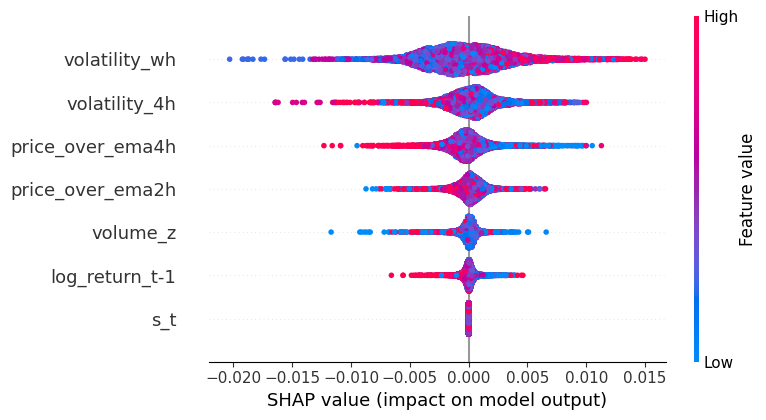

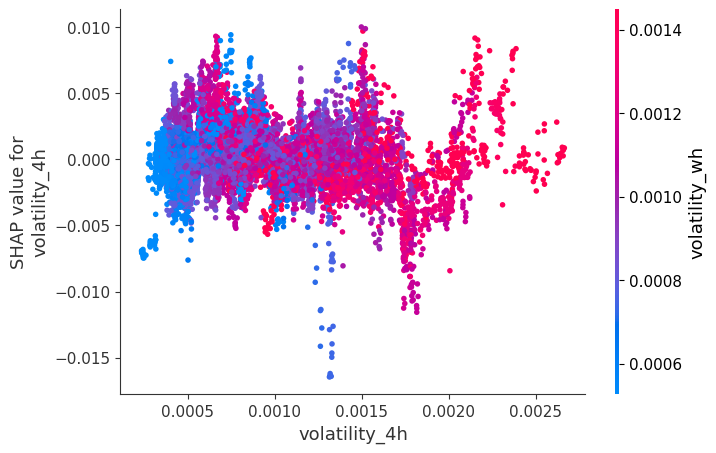

In [23]:
scores = train_and_save_scores(X, y, n_splits=5)

In [24]:
save_dict_to_json(scores, "xgb_feature_importance.ipynb")